# Fitting a Line to Data

In this tutorial, we'll go through how to fit a straight line `y = m*x + b` to data. This will come up a lot in this project, and in the rest of your life!

In [70]:
import numpy as np # for maths 
import matplotlib as mpl # for plotting 
import matplotlib.pyplot as plt

from tqdm import tqdm # tqdm is a package that lets you make progress bars to see how a loop is going

import os 

# configure notebook for plotting
%matplotlib inline

mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme

# subsequent lines default plot settings
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.figsize']=(8.0,6.0)   
mpl.rcParams['font.size']=16              
mpl.rcParams['savefig.dpi']= 300             

import warnings
warnings.filterwarnings('ignore')

First, let's generate some fake data, from the line `y = 12*x - 5` for `x` in (0,2.5), with Gaussian noise of σ=2.

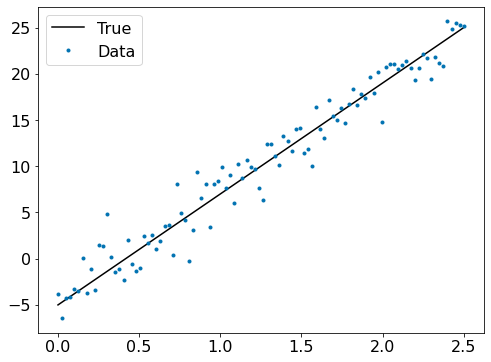

In [71]:
x = np.linspace(0,2.5,100)
noise = 2*np.random.randn(len(x))
y = 12*x -5  + noise

plt.plot(x,12*x-5,'-k',label='True')
plt.plot(x,y,'.',label='Data')

plt.legend()

To fit a straight line to these data, we can easily do this by least squares - ie, minimizing the sum of the squares of the error: `(model-data)**2`. 

We can express our problem as `y = A @ b`, for a 2xN 'design matrix' `A` whose first column is `x` and second column is all `1`, and a 'coefficient vector' `b`.

This has an easy solution by computational linear algebra, implemented as `np.linalg.lstsq`.

True parameters: 12, -5. Recovered parameters: 11.65, -4.44


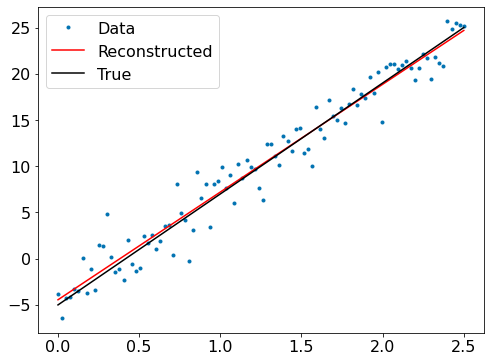

In [72]:
A = np.vander(x,2) # the Vandermonde matrix of order N is the matrix of polynomials of an input vector 1, x, x**2, etc

b, residuals, rank, s = np.linalg.lstsq(A,y)
print('True parameters: 12, -5. Recovered parameters: %.2f, %.2f' % (b[0],b[1]))

reconstructed = A @ b # @ is shorthand for matrix multiplication in python

plt.plot(x,y,'.',label='Data')
plt.plot(x,reconstructed,'-r',label='Reconstructed')
plt.plot(x,12*x-5,'-k',label='True')
plt.legend()

So far so good! But science is about uncertainties. How can we estimate the uncertainties on the slope and intercept? 

Enter the Monte Carlo method - named for a famous casino, Monte Carlo is the idea of using random number generation to solve problems in computer science.

Here, what we can do, is simulate *many* datasets with the same noise as the data we have, and fit lines to those, to estimate the range of possible lines that fit our data.

100%|██████████| 1000/1000 [00:01<00:00, 819.75it/s]


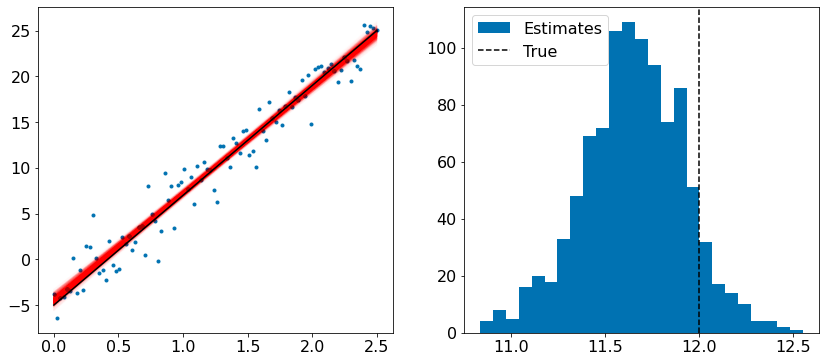

In [73]:
bs = np.zeros((2,1000))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14.0,6.0))

ax1.plot(x,y,'.')

for j in tqdm(range(1000)):
    ydash = y + 2*np.random.randn(len(x)) # generate random samples
    bdash, _, _, _ = np.linalg.lstsq(A,ydash) # for each sample, redo the solve
    reconstructed = A @ bdash # @ is shorthand for matrix multiplication in python

    bs[:,j] = bdash
    ax1.plot(x,reconstructed,'-r',alpha=0.01) # plot with low alpha = transparent, great way to show density of many curves

ax1.plot(x,12*x-5,'-k')

ax2.hist(bs[0],bins=25,label='Estimates'); # 0 is slope, 1 is intercept
ax2.axvline(12.0,color='k',linestyle='--',label='True')
ax2.legend()

Great! We can now quantify the uncertainty in our estimates of the slope. 

For you to think about:

- How would you fit a line if there are uncertainties in both `x` and `y`?
- Our fitting isn't ideal if your uncertainties aren't exactly iid Gaussian. Try looking up Markov Chain Monte Carlo, which is the best way to fit *any* model to *any* data and get uncertainties in your model parameters. 
    - [Code tutorial](https://emcee.readthedocs.io/en/stable/tutorials/line/) on MCMC with Python package `emcee` by Dan Foreman-Mackey 
    - Theory paper explaining why you do this by Hogg et al: [arXiv:1008.4686](https://arxiv.org/abs/1008.4686)